The Titanic Kaggle Competition is the opening project to start. So just to say I've done it, here it is. Just a quick run through of the competition.

Double hashtags are explanative test and single hashtags are code

## Initial Data Import

In [1]:
## Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Scikit-Learn

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier

In [2]:
## Import Data

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
## We run into a practical vs theoretical conflict
## The test data should always stay dark but
## the data should be manipulated together and consistently

unsplit_data = train.append(test, ignore_index=True)

## We can find test data with the below code
## Just look for where we haven't given died or survived value.

# np.where(unsplit_data['Survived'].isnull())[0]

## Initial Exploration

We have missing data and have to fill it in. We can also see that we have 418 rows that are our test data

In [4]:
unsplit_data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In order to get a sense of the data, we can look at some basic summary statistics. But keeping in mind that having empty values will shift the values

In [5]:
## Summary Statistics

train.dropna().describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,455.366120,0.672131,1.191257,35.674426,0.464481,0.475410,78.682469
std,247.052476,0.470725,0.515187,15.643866,0.644159,0.754617,76.347843
min,2.000000,0.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,263.500000,0.000000,1.000000,24.000000,0.000000,0.000000,29.700000
50%,457.000000,1.000000,1.000000,36.000000,0.000000,0.000000,57.000000
75%,676.000000,1.000000,1.000000,47.500000,1.000000,1.000000,90.000000
max,890.000000,1.000000,3.000000,80.000000,3.000000,4.000000,512.329200


In order to plot the data we have to factorize them into numbers for python.

In [6]:
embarked_values = pd.factorize(train['Embarked'])

train['Embarked_value'] = embarked_values[0]

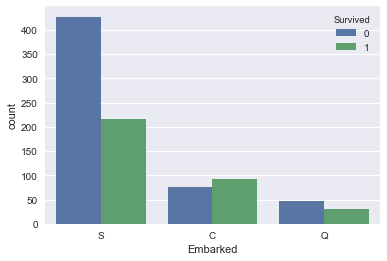

In [7]:
%matplotlib inline

sns.countplot(x = "Embarked", hue="Survived", data = train)

We can also see an effect on survived by other factors as well.

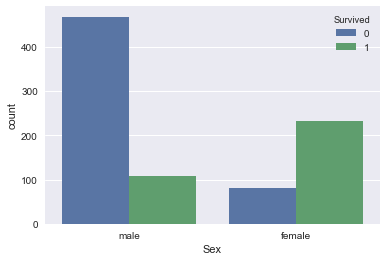

In [8]:
sns.countplot(x = "Sex", hue = "Survived", data = train)

   ## Dummify categoricals

We can also split the fares into 4 quantiles to help categorize people

In [9]:
fares = pd.qcut(unsplit_data['Fare'],4, labels=[0,1,2,3])

# fares.tolist().count(0)
# 323, 328, 320, 337

We need to create dummy variables in order to run scikit learn functions

In [10]:
Fares = pd.get_dummies(fares, prefix = "Fare")
Embarked = pd.get_dummies(unsplit_data['Embarked'], prefix = "Embarked")
Pclass = pd.get_dummies(unsplit_data['Pclass'], prefix = "Pclass")
Sex = pd.Series(np.where(unsplit_data['Sex'] == 'male', 1, 0), name = "Sex")

Then we can join all our dummified data and current data together

In [11]:
unsplit_dummied = pd.concat([Pclass, Sex, Embarked, Fares, unsplit_data[['Age','Parch','PassengerId','SibSp','Survived','Fare']]], axis = 1)

## Feature Engineering

We can take some less than clean data and create features we can use

#### Societal Status

In [12]:
titles = unsplit_data['Name'].str.extract('([A-z]+)\.', expand = False)

In [13]:
set(titles)

{'Capt',
 'Col',
 'Countess',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir'}

In [14]:
title_map = {}

groupings = ["Millitary","Royalty","Professional","Regular"]
titles_grouped = [
    ["Capt", "Col", "Major",], 
    ['Jonkheer', 'Don', "Sir", "Countess", "Dona","Lady"],
    ['Dr', 'Rev'],
    ['Mme', 'Mlle', 'Ms', "Mr", "Mrs", "Miss", "Master"]]

The following code creates a key-value set that assigns each title a grouping

In [15]:
for grouping, grouped_title in zip(groupings,titles_grouped):
    for title in grouped_title:
        title_map[title] = grouping

We can now go through the data and map the grouping for each row of data

In [16]:
unsplit_data["Society"] = titles.map(title_map)

Now that we've created the feature (column), we can add it to the data

In [17]:
Society = pd.get_dummies(unsplit_data.Society, prefix="Society")

In [18]:
unsplit_dummied = pd.concat([unsplit_dummied, Society], axis = 1)

#### Cabin Class

In [19]:
Cabin_types = unsplit_data.Cabin.str.extract('([A-z]*)[0-9]*', expand = False)
Cabin_types = Cabin_types.fillna('Unk')

In [20]:
Cabin_types = pd.get_dummies(Cabin_types, prefix="Cabin_group")

In [21]:
unsplit_dummied = pd.concat([unsplit_dummied, Cabin_types], axis = 1)

Cabin Class is actually better defined as deck levels as we can find here. Sadly we're missing so much data in the data set we can't figure out where people were staying left-right and forward-back. But if you wanted to extract them you could use this regex.

https://www.encyclopedia-titanica.org/titanic-deckplans/c-deck.html

In [22]:
# raw_location = unsplit_data.Cabin.str.extract('[A-z]*([0-9]*)', expand = False)

#### Age

Let's try to impute the missing ages. We'll try linear regression, SVR, and kNN but they're pretty bad at it. I've left the last one - kNN to show how poorly they have been. I decided to stick with just doing the median age.

In [23]:
# This just grabs all the categories we want to try to use to predict age. 
# We need this because we dummified the categorical variables
categories_to_predict = [col for col in unsplit_dummied.columns if 'Pclass' in col or 'Sex' in col or 'Age' in col]


In [24]:
# Take the rows with age data only. I know, I know we're using test data too 
# but we're not trying to fill in survival but impute data.

# train data
data_with_ages = unsplit_dummied[categories_to_predict].dropna()

In [51]:
# Create the data whom's age we need to impute

# test data
na_ages_unfiltered = unsplit_dummied[unsplit_dummied['Age'].isnull()]
na_ages = na_ages_unfiltered[categories_to_predict]

In [52]:
# Fit out classifier
age_guess = KNeighborsClassifier()
age_guess.fit(data_with_ages.drop('Age', axis=1), np.round (np.ravel(data_with_ages[['Age']])) )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [56]:
# Comparing our predictions of training data
preds = pd.Series(np.round(age_guess.predict(data_with_ages.drop('Age', axis = 1))))


In [60]:
# How off are we on average.
np.mean(np.array(data_with_ages[['Age']]) - np.array(preds))

17.913642447418738

In [ ]:
new = data_with_ages

In [ ]:
new['pred'] = preds

In [ ]:
new.head()

#### Ticket Info

In [ ]:
store = unsplit_data.Ticket.str.extract('(.*) ', expand = False)
store = store.fillna('Unk')

In [ ]:
thing = store.map(lambda x: x.upper().replace('/',"").replace('.','') )

In [ ]:
thing2 = thing.str.extract('([A-z]*)', expand=False)
thing2.groupby(thing2).count()

#### Family Size

In [ ]:
Family_count = unsplit_data['Parch'] + unsplit_data['SibSp']

In [ ]:
def fam_size(x):
    if x == 0:
        return("Alone")
    elif 1<=x<=4:
        return("Normal")
    else:
        return("Large")

Family_count = Family_count.map(fam_size)

In [ ]:
Fam_dummied = pd.get_dummies(Family_count, prefix="Family")

In [ ]:
unsplit_dummied = pd.concat([unsplit_dummied, Fam_dummied], axis=1)

   ## Transform train and test equally

In [ ]:
test_indicies = np.where(unsplit_dummied['Survived'].isnull())[0]

train_indicies = list(range(len(unsplit_data))) 

In [ ]:
train_indicies = np.delete(train_indicies, test_indicies)

In [ ]:
len(train_indicies)

In [ ]:
new_train = unsplit_dummied.iloc[train_indicies]
new_test = unsplit_dummied.iloc[test_indicies]

In [ ]:
## Separate data in explanatory (X) and response (y)

y_train = new_train['Survived']
X_train = new_train.drop('Survived', axis=1)

X_test = new_test.drop('Survived', axis=1)

In [ ]:
X_train.shape

In [ ]:
X_train.isnull().sum()

In [ ]:
X_train['Age'] = X_train.fillna( X_train.Age.median())

X_train['Fare'] = X_train.fillna( X_train.Fare.median())

X_test['Age'] = X_test.fillna( X_test.Age.median())

X_test['Fare'] = X_test.fillna( X_test.Fare.median())

## Feature Selection

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

In [ ]:
fet_sel = pd.DataFrame()
fet_sel['feature'] = X_train.columns
fet_sel['importance'] = clf.feature_importances_

In [ ]:
fet_sel.sort(['importance'], ascending=False)

In [ ]:
model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train)
X_train_new.shape



In [ ]:
X_test_new = model.transform(X_test)
X_test_new.shape



## Models

Decision Tree Classifier

In [ ]:
DT = DecisionTreeClassifier(max_depth=3)
DT.fit(X_train, y_train)

DT_y_train_pred = DT.predict(X_train)
DT_y_test_pred = DT.predict(X_test)

DT_train_acc = np.sum(y_train == DT_y_train_pred)/len(y_train)
print(DT_train_acc)

In [ ]:
np.mean(cross_val_score(DT, X_train, y_train, cv = 10))

Random Forest Classifier

In [ ]:
RF = RandomForestClassifier(max_features="sqrt", 
                            max_depth=5, 
                            n_estimators=220, 
                            criterion="gini")

RF.fit(X_train, y_train)

RF_y_train_pred = RF.predict(X_train)
RF_y_test_pred = RF.predict(X_test)

RF_train_acc = np.sum(y_train == RF_y_train_pred)/len(y_train)
print(RF_train_acc)

In [ ]:
np.mean(cross_val_score(RF, X_train, y_train, cv = 10))

AdaBoostClassifier

In [ ]:
ABC = AdaBoostClassifier(n_estimators=5)
ABC.fit(X_train, y_train)

ABC_y_train_pred = ABC.predict(X_train)
ABC_y_test_pred = ABC.predict(X_test)

ABC_train_acc = np.sum(y_train == ABC_y_train_pred)/len(y_train)
print(ABC_train_acc)

In [ ]:
np.mean(cross_val_score(ABC, X_train, y_train, cv = 10))

Logistic Regression

In [ ]:
LR = LogisticRegression(C=1e4)
LR.fit(X_train, y_train)

LR_y_train_pred = LR.predict(X_train)
LR_y_test_pred = LR.predict(X_test)

LR_train_acc = np.sum(y_train == LR_y_train_pred)/len(y_train)
print(LR_train_acc)

In [ ]:
np.mean(cross_val_score(LR, X_train, y_train, cv = 10))

## Export Predictions

In [ ]:
output_pred = pd.DataFrame({ 'PassengerID': X_test['PassengerId'], 
                            'Survived' : RF_y_test_pred.astype(int)
                           })

output_pred.to_csv( './data/predictions.csv', index = False)